In [25]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import json
import os
import cPickle as pickle
import cv2


In [19]:
ClassFile = "../Logs/classes.json"

vineScores = "../Logs/sampledvineSentibankProbs2015_3.csv"
#selfieScores = "../Logs/selfieSentibankProbs.csv"

vinePaths = "../Logs/sampledvineSentibankANPS2015_3.pk"
#selfiePaths = "../Logs/selfiePaths.txt"

imageNetObjs = "../Logs/sampledvineImagenetObjs2015_1.pk"

#selfiePopularityFile = "../Logs/selfie_dataset.txt"

root = "../vinedata/Data/"

visitedList = "../Logs/sampledVids.data"

sentimentFile = "../Logs/ANP_Sentiments.txt"

In [6]:
def getVisited():
    visited = []
    f = open(visitedList, 'rb')
    visited = pickle.load(f)
    return visited


def walkLevel1Dir(root):
    count = 0
    dirList = []
    filesList = []
    for path, dirs, files in os.walk(root):
        if count > 0:
            return dirList , fileList
        dirList = dirs
        fileList = files
        count = count + 1


def getPopularFile(rootDir):
    f = open(rootDir + '/popular.json' ,'r')
    data = json.load(f)
    return data

    
    
def getPopularPosts(popular , loopThreshold):
    records = popular['data']['records']
    posts=[]
    for i in range (0 , len(records)):
        loopCount = records[i]['reposts']['count']
        if(loopCount > loopThreshold):
            posts.append(records[i])
    return posts

def getRecords(popular):
    records = popular['data']['records']
    return records

def find(lst, val):
    return [i for i, x in enumerate(lst) if x == val]

def readSentiments():
    with open(sentimentFile) as g:
        sentiList = g.readlines()
    sentiDict = dict()
    for line in sentiList:
        arr = line.split(' ')
        ANP = arr[0]
        sentiment = float(arr[2].replace(']',''))
        sentiDict[ANP] = sentiment
    return sentiDict
        

In [4]:
#Load the Sentibank scores for both selfies and Vines
vineProbs = np.loadtxt(vineScores, delimiter=',')

In [7]:
f = open(ClassFile ,'r')
sentibankClasses = json.load(f)
f.close()

# with open(vinePaths) as g:
#     vineList = g.readlines()


In [8]:
vineList = []
infile = open(vinePaths, 'rb')
while 1:
    try:
        vineList.append(pickle.load(infile))
    except (EOFError):
        break
infile.close()

In [20]:
objList = []
infile = open(imageNetObjs, 'rb')
while 1:
    try:
        objList.append(pickle.load(infile))
    except (EOFError):
        break
infile.close()

In [9]:
sentidict = readSentiments()

/datasets/sagarj/vineData/sampledFrames/1283620080978427904_7.jpg,handsome_guy,0.0236451,horizontal_text,0.0186075,outdoor_training,0.0172037,attractive_male,0.0164906,amazing_race,0.0157895
/datasets/sagarj/vineData/sampledFrames/1283620080978427904_7.jpg,label,neck


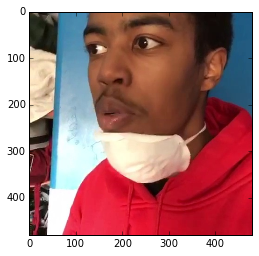

In [46]:
num = 10020
print vineList[num]
print objList[num]
img = cv2.imread(vineList[num].split(',')[0],1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

In [ ]:
print len(vineList)

In [ ]:
postIds = []
for line in vineList:
    arr = line.split('/')
    i = int(arr[5].split('_')[0])
    postIds.append(i)

In [ ]:
# dirs,files = walkLevel1Dir(root)
# visited = getVisited()
# selectedPosts = []
# allPosts = []


# for d in dirs:
#     if d in visited:
#         dataRoot = root + d
#         popular = getPopularFile(dataRoot)
#         rec = getRecords(popular)
#         allPosts += rec